In [1]:
%pip install -v Mathics3 pymathics-graph ipywidgets lxml pyocr scikit-image unidecode wordcloud

In [2]:
from io import BytesIO
import json
import math
from matplotlib import pyplot
import networkx as nx
import random
from typing import Callable

from mathics.core.atoms import SymbolString
from mathics.core.expression import BoxError, Expression
from mathics.core.symbols import Symbol
from mathics.core.systemsymbols import (
    SymbolCompiledFunction,
    SymbolFullForm,
    SymbolGraphics,
    SymbolGraphics3D,
    SymbolInputForm,
    SymbolMathMLForm,
    SymbolOutputForm,
    SymbolStandardForm,
    SymbolTeXForm,
)
from mathics.session import get_settings_value
from mathics.core.definitions import Definitions, autoload_files
from mathics.core.evaluation import Evaluation, Output
from mathics.core.load_builtin import import_and_load_builtins
from mathics.core.definitions import Definitions
from mathics.core.evaluation import Message, Result
from mathics.settings import TIMEOUT, default_pymathics_modules

# From mathics-django

PyMathicsGraph = Symbol("Pymathics`Graph")

FORM_TO_FORMAT = {
    "System`MathMLForm": "xml",
    "System`TeXForm": "tex",
    "System`FullForm": "text",
    "System`OutputForm": "text",
}


def format_output(obj, expr, format=None):
    """
    Handle unformatted output using the *specific* capabilities of mathics-django.

    evaluation.py format_output() from which this was derived is similar but
    it can't make use of a front-ends specific capabilities.
    """

    def eval_boxes(result, fn: Callable, obj, **options):
        options["evaluation"] = obj
        try:
            boxes = fn(**options)
        except BoxError:
            boxes = None
            if not hasattr(obj, "seen_box_error"):
                obj.seen_box_error = True
                obj.message(
                    "General",
                    "notboxes",
                    Expression(SymbolFullForm, result).evaluate(obj),
                )

        return boxes

    if format is None:
        format = obj.format

    if isinstance(format, dict):
        return dict((k, obj.format_output(expr, f)) for k, f in format.items())

    # For some expressions, we want formatting to be different.
    # In particular for FullForm output, we don't want MathML, we want
    # plain-ol' text so we can cut and paste that.

    expr_type = expr.get_head_name()
    expr_head = expr.get_head()
    if expr_head in (SymbolMathMLForm, SymbolTeXForm):
        # For these forms, we strip off the outer "Form" part
        format = FORM_TO_FORMAT[expr_type]
        elements = expr.get_elements()
        if len(elements) == 1:
            expr = elements[0]

    if expr_head in (SymbolFullForm, SymbolOutputForm):
        result = expr.elements[0].format(obj, expr_type)
        return result.boxes_to_text()
    elif expr_head is SymbolGraphics:
        result = Expression(SymbolStandardForm, expr).format(
            obj, SymbolMathMLForm
        )

    # This part was derived from and the same as evaluation.py format_output.

    use_quotes = get_settings_value(obj.definitions, "Settings`$QuotedStrings")

    if format == "text":
        result = expr.format(obj, SymbolOutputForm)
        result = eval_boxes(result, result.boxes_to_text, obj)

        if use_quotes:
            result = '"' + result + '"'

        return result
    elif format == "xml":
        result = Expression(SymbolStandardForm, expr).format(
            obj, SymbolMathMLForm
        )
    elif format == "tex":
        result = Expression(SymbolStandardForm, expr).format(
            obj, SymbolTeXForm
        )
    elif format == "unformatted":
        if expr_head is PyMathicsGraph and hasattr(expr, "G"):
            return format_graph(expr.G)
        if expr_head is SymbolCompiledFunction:
            result = expr.format(obj, SymbolOutputForm)
        elif expr_head is SymbolString:
            result = expr.format(obj, SymbolInputForm)
            result = result.boxes_to_text()

            if not use_quotes:
                # Substring without the quotes
                result = result[1:-1]

            return result
        elif expr_head is SymbolGraphics3D:
            form_expr = Expression(SymbolStandardForm, expr)
            result = form_expr.format(obj, SymbolStandardForm)
            return eval_boxes(result, result.boxes_to_json, obj)
        elif expr_head is SymbolGraphics:
            form_expr = Expression(SymbolStandardForm, expr)
            result = form_expr.format(obj, SymbolStandardForm)
            return eval_boxes(result, result.boxes_to_svg, obj)
        else:
            result = Expression(SymbolStandardForm, expr).format(
                obj, SymbolTeXForm
            )
            return (
                r"\[" + eval_boxes(result, result.boxes_to_text, obj) + r"\]"
            )
    else:
        raise ValueError

    if result is None:
        return f"Error in evaluating {expr}"
    return eval_boxes(result, result.boxes_to_text, obj)


cached_pair = None


def hierarchy_pos(
    G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, leaf_vs_root_factor=0.5
):
    """Position nodes in tree layout. The root is at the top.

    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.

    There are two basic approaches we think of to allocate the horizontal
    location of a node.

    - Top down: we allocate horizontal space to a node.  Then its ``k``
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.

    We use use both of these approaches simultaneously with ``leaf_vs_root_factor``
    determining how much of the horizontal space is based on the bottom up
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.

    From EoN (Epidemics on Networks): a fast, flexible Python package
    for simulation, analytic approximation, and analysis of epidemics
    on networks
    https://joss.theoj.org/papers/10.21105/joss.01731

    :Arguments:

    Parameters
    ----------
    G : NetworkX graph or list of nodes
        A position will be assigned to every node in G.
        The graph must be a tree.

    root : the root node of the tree

    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    width : horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap : gap between levels of hierarchy

    vert_loc : vertical location of root

    leaf_vs_root_factor : used in calculating the _x_ coordinate of a leaf

    xcenter : horizontal location of root

    Examples
    --------
    >>> G = nx.binomial_tree(3)
    >>> nx.draw(G, pos=nx.hierarchy_layout(G, root=0))

    As the number of nodes gets large, the node size and node labels
    may need to be adjusted. The following shows how the minimum
    separation between nodes can be used to adjust node sizes.

    >>> G = nx.full_rary_tree(2, 127)
    >>> pos, min_sep = nx.hierarchy_layout_with_min_sep(G, root=0)
    >>> nx.draw(G, pos=pos, node_size=min_sep * 1500)

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    """
    if not nx.is_tree(G):
        raise TypeError(
            "cannot use hierarchy_pos on a graph that is not a tree"
        )

    global cached_pair
    if cached_pair is not None:
        return cached_pair

    # These get swapped if tree edge directions point to the root.
    descendants = nx.descendants
    out_degree = G.out_degree if hasattr(G, "out_degree") else G.degree
    neighbors = G.neighbors

    if root is None:
        if isinstance(G, nx.DiGraph):
            zero_outs = [n for n in G.out_degree() if n[1] == 0]
            if len(zero_outs) == 1 and len(G) > 2:
                # We unequivocally have a directed that points from leave to the root.
                # The case where we have a one or two node graph is ambiguous.
                root = list(nx.topological_sort(G))[-1]
                # Swap motion functions
                descendants = nx.ancestors
                out_degree = G.in_degree
                neighbors = G.predecessors
            else:
                root = next(
                    iter(nx.topological_sort(G))
                )  # allows back compatibility with nx version 1.11
                # root = next(nx.topological_sort(G))
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(
        G,
        root,
        leftmost,
        width,
        leafdx=0.2,
        vert_gap=0.2,
        vert_loc=0,
        xcenter=0.5,
        rootpos=None,
        leafpos=None,
        parent=None,
    ):
        """
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        """

        if rootpos is None:
            rootpos = {root: (xcenter, vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}

        children = list(neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children) != 0:
            rootdx = width / len(children)
            nextx = xcenter - width / 2 - rootdx / 2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(
                    G,
                    child,
                    leftmost + leaf_count * leafdx,
                    width=rootdx,
                    leafdx=leafdx,
                    vert_gap=vert_gap,
                    vert_loc=vert_loc - vert_gap,
                    xcenter=nextx,
                    rootpos=rootpos,
                    leafpos=leafpos,
                    parent=root,
                )
                leaf_count += newleaves

            leftmostchild = min(
                (x for x, y in [leafpos[child] for child in children])
            )
            rightmostchild = max(
                (x for x, y in [leafpos[child] for child in children])
            )
            leafpos[root] = ((leftmostchild + rightmostchild) / 2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root] = (leftmost, vert_loc)
        #        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
        #        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width / 2.0
    if isinstance(G, nx.DiGraph):
        leafcount = len(
            [node for node in descendants(G, root) if out_degree(node) == 0]
        )
    elif isinstance(G, nx.Graph):
        leafcount = len(
            [
                node
                for node in nx.node_connected_component(G, root)
                if G.degree(node) == 1 and node != root
            ]
        )

    rootpos, leafpos, leaf_count = _hierarchy_pos(
        G,
        root,
        0,
        width,
        leafdx=width * 1.0 / leafcount,
        vert_gap=vert_gap,
        vert_loc=vert_loc,
        xcenter=xcenter,
    )
    pos = {}
    for node in rootpos:
        pos[node] = (
            leaf_vs_root_factor * leafpos[node][0]
            + (1 - leaf_vs_root_factor) * rootpos[node][0],
            leafpos[node][1],
        )
    #    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x, y in pos.values())
    y_list = {}
    for node in pos:
        x, y = pos[node] = (pos[node][0] * width / xmax, pos[node][1])
        y_list[y] = y_list.get(y, set([]))
        y_list[y].add(x)

    min_sep = xmax
    for y in y_list.keys():
        x_list = sorted(y_list[y])
        n = len(x_list) - 1
        if n <= 0:
            continue
        min_sep = min(
            [x_list[i + 1] - x_list[i] for i in range(n)] + [min_sep]
        )
    cached_pair = pos, min_sep
    return cached_pair


node_size = 300  # this is networkx's default size


def tree_layout(G):
    global node_size
    root = G.root if hasattr(G, "root") else None
    pos, min_sep = hierarchy_pos(G, root=root)
    node_size = min_sep * 2000
    return pos


def spiral_equidistant_layout(G, *args, **kwargs):
    return nx.spiral_layout(G, equidistant=True, *args, **kwargs)


NETWORKX_LAYOUTS = {
    "circular": nx.circular_layout,
    "kamada_kawai": nx.kamada_kawai_layout,
    "multipartite": nx.multipartite_layout,
    "planar": nx.planar_layout,
    "random": nx.random_layout,
    "shell": nx.shell_layout,
    "spectral": nx.spectral_layout,
    "spiral": nx.spiral_layout,
    "spiral_equidistant": spiral_equidistant_layout,
    "spring": nx.spring_layout,
    "tree": tree_layout,
}

LAYOUT_DENSITY_EXPONENT = {
    "circular": 0.9,
    "spiral_equidistant": 0.7,
    "spiral": 0.6,
}


def clamp(value, min=-math.inf, max=math.inf):
    if value <= min:
        return min
    if value >= max:
        return max
    return value


DEFAULT_NODE_SIZE = 300.0
DEFAULT_POINT_SIZE = 16


def harmonize_parameters(G, draw_options: dict):
    global node_size
    graph_layout = G.graph_layout if hasattr(G, "graph_layout") else ""

    if graph_layout == "tree":
        # Call this to compute node_size. Cache the
        # results
        tree_layout(G)
        draw_options["node_size"] = node_size
    elif graph_layout in ["circular", "spiral", "spiral_equidistant"]:
        exponent = LAYOUT_DENSITY_EXPONENT[graph_layout]
        node_size = draw_options["node_size"] = (2 * DEFAULT_NODE_SIZE) / (
            len(G) + 1
        ) ** exponent
        # print("XX", node_size, exponent)

    if draw_options.get("with_labels", False):
        draw_options["edgecolors"] = draw_options.get("edgecolors", "black")
        draw_options["node_color"] = draw_options.get("node_color", "white")

    if "width" not in draw_options:
        width = clamp(node_size / DEFAULT_NODE_SIZE, min=0.15)
        draw_options["width"] = width

    if "font_size" not in draw_options:
        # FIXME: should also take into consideration max width of label.
        font_size = clamp(
            int((node_size * DEFAULT_POINT_SIZE) / DEFAULT_NODE_SIZE),
            min=1,
            max=18,
        )
        draw_options["font_size"] = font_size


def format_graph(G) -> str:
    """
    Format a networkx graph using nx.draw (using matplotlib) and
    return a SVG string that encodes the graph.
    """

    global node_size
    global cached_pair

    # Make sure we close any previous graph before starting to create
    # new graph.
    pyplot.close()

    pyplot.switch_backend("AGG")
    cached_pair = None

    graph_layout = G.graph_layout if hasattr(G, "graph_layout") else None
    node_shape = G.node_shape if hasattr(G, "node_shape") else "o"

    node_size = DEFAULT_NODE_SIZE
    draw_options = {
        "node_size": node_size,
        "node_shape": node_shape,
        # "with_labels": vertex_labels # Set below
        # "font_size": 12,        # Harmonized
        # "node_color": "white",  # Set below
        # "edgecolors": "black",  # Set below
        # "width": 5,             # Marmonized
    }

    vertex_labels = G.vertex_labels if hasattr(G, "vertex_labels") else False
    if vertex_labels:
        draw_options["with_labels"] = bool(vertex_labels)

    if hasattr(G, "title") and G.title:
        fig, ax = pyplot.subplots()  # Create a figure and an axes
        ax.set_title(G.title)

    layout_fn = None
    if graph_layout:
        if not isinstance(graph_layout, str):
            graph_layout = graph_layout.get_string_value()
        layout_fn = NETWORKX_LAYOUTS.get(graph_layout, None)
        if graph_layout in ["circular", "spiral", "spiral_equidistant"]:
            pyplot.axes().set_aspect("equal")

    harmonize_parameters(G, draw_options)

    if layout_fn:
        nx.draw(G, pos=layout_fn(G), **draw_options)
    else:
        nx.draw_shell(G, **draw_options)

    # pyplot.tight_layout()
    svg_graph_xml = get_graph()
    svg_str = svg_graph_xml[svg_graph_xml.find("<svg xmlns:xlink") :]
    return svg_str


def get_graph() -> str:
    """
    Retrieves SVG XML from what has already been stored the matplotlib buffer
    pyplot. Return the XML SVG string.
    """

    buffer = BytesIO()
    pyplot.savefig(buffer, format="svg")
    buffer.seek(0)
    graph_svg = buffer.getvalue()
    buffer.close()

    # TODO: In the future if probably want to base64 encode.
    # Use: base64.b64encode(some piece of image_svg)
    return graph_svg.decode("utf-8")


import_and_load_builtins()

definitions = Definitions(add_builtin=True)
# We set the formatter to "unformatted" so that we can use
# our own custom formatter that understand better how to format
# in the context of mathics-django.
# Previously, one specific format, like "xml" had to fit all.
evaluation = Evaluation(definitions, format="unformatted")
evaluation.format_output = lambda expr, format: format_output(
    evaluation, expr, format
)


from IPython.display import HTML, Math


def eval_mathics(query):
    data = evaluation.parse_evaluate(query).get_data()
    result = data["result"].strip()
    if result.startswith("<svg") or result.startswith("<math"):
        result = result.replace("<math", "<div")
        result = result.replace(
            "<mglyph", '<img style="display: inline-block" '
        )
        result = result.replace("<mrow>", "")
        result = result.replace("<mo>", "")
        return HTML(result)
    if data["form"] == "TeXForm":
        return Math(result)
    if result.startswith(r"\["):
        result = result.replace(r"\[", "")
        result = result.replace(r"\]", "")
        return Math(result)
    if result.startswith('{"elements":'):
        return json.loads(result)
    return result


print(eval_mathics('LoadModule["pymathics.graph"]'))

[Errno 28] Invalid argument: '.'
    Not able to load mathics.builtin.exp_structure.size_and_sig. Check your installation.
    mathics.builtin loads from /lib/python3.12/site-packages/mathics/core/load
[Errno 28] Invalid argument: '.'
    Not able to load mathics.builtin.pympler.asizeof. Check your installation.
    mathics.builtin loads from /lib/python3.12/site-packages/mathics/core/load
[Errno 28] Invalid argument: '.'
    Not able to load mathics.builtin.file_operations.file_properties. Check your installation.
    mathics.builtin loads from /lib/python3.12/site-packages/mathics/core/load


/lib/python3.12/site-packages/mathics/builtin/quantum_mechanics/angular.py:89: SyntaxWarning: invalid escape sequence '\['
  """


pymathics.graph


In [3]:
eval_mathics("ArcCos[0]")

<IPython.core.display.Math object>

In [4]:
eval_mathics(
    "Graphics[Table[{Hue[h, s], Disk[{12h, 8s}]}, {h, 0, 1, 1/6}, {s, 0, 1, 1/4}]]"
)

In [5]:
eval_mathics("Plot[{Sin[x], Cos[x], x ^ 2}, {x, -1, 1}]")

In [6]:
eval_mathics(
    """
    f[x_] := 4 x / (x ^ 2 + 3 x + 5);
    {f'[x], f''[x], f'''[x]} // Together
    """
)

<IPython.core.display.Math object>

In [7]:
eval_mathics(
    "Graphics[Table[{EdgeForm[{GrayLevel[0, 0.5]}], Hue[(-11+q+10r)/72, 1, 1, 0.6], Disk[(8-r){Cos[2Pi q/12], Sin[2Pi q/12]}, (8-r)/3]}, {r, 6}, {q, 12}]]"
)


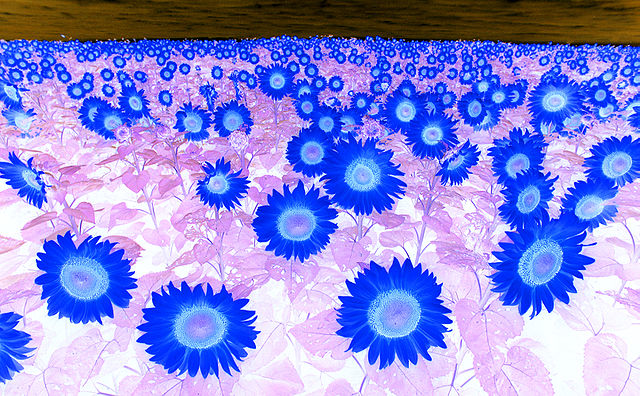

In [8]:
eval_mathics('ColorNegate[Import["ExampleData/sunflowers.jpg"]] // MathMLForm')

In [9]:
eval_mathics('DominantColors[Import["ExampleData/hedy.tif"]] // MathMLForm')

In [10]:
eval_mathics(
    'Graphics[Table[{AbsoluteThickness[t], Line[{{20 t, 10}, {20 t, 80}}], Text[ToString[t]<>"pt", {20 t, 0}]}, {t, 0, 10}]]'
)

In [11]:
eval_mathics(
    "Table[Graphics[{Circle[], Arrow[Table[{Cos[phi],Sin[phi]},{phi,0,2*Pi,Pi/2}],{d, d}]}],{d,0,2,0.5}] // MathMLForm"
)

In [12]:
eval_mathics(
    "Table[Style[Graphics[{EdgeForm[{Black}], RGBColor[r,g,b], Rectangle[]}], ImageSizeMultipliers->{0.2, 1}], {r,0,1,1/2}, {g,0,1,1/2}, {b,0,1,1/2}] // TableForm // MathMLForm"
)

In [13]:
eval_mathics(
    """
    collatz[1] := 1;
    collatz[x_ ? EvenQ] := x / 2;
    collatz[x_] := 3 x + 1;
    list = FixedPointList[collatz, 14];
    ListLinePlot[list]
    """
)

In [14]:
eval_mathics(
    """
    vertices = {{0,0}, {1,0}, {.5, .5 Sqrt[3]}};
    points = NestList[.5(vertices[[ RandomInteger[{1,3}] ]] + #)&, {0.,0.}, 1000];
    Graphics[Point[points], ImageSize->Large]
    """
)

In [15]:
eval_mathics("ListLinePlot[Table[Sin[x], {x, -5, 5, 0.2}], Filling->Axis]")

In [16]:
eval_mathics("DensityPlot[Sin[x y], {x, -2, 2}, {y, -2, 2}, Mesh->Full]")

In [17]:
eval_mathics("ParametricPlot[{Sin[u], Cos[3 u]}, {u, 0, 2 Pi}]")

In [18]:
eval_mathics("Clear[t]; PolarPlot[{1, 1 + Sin[20 t] / 5}, {t, 0, 2 Pi}]")


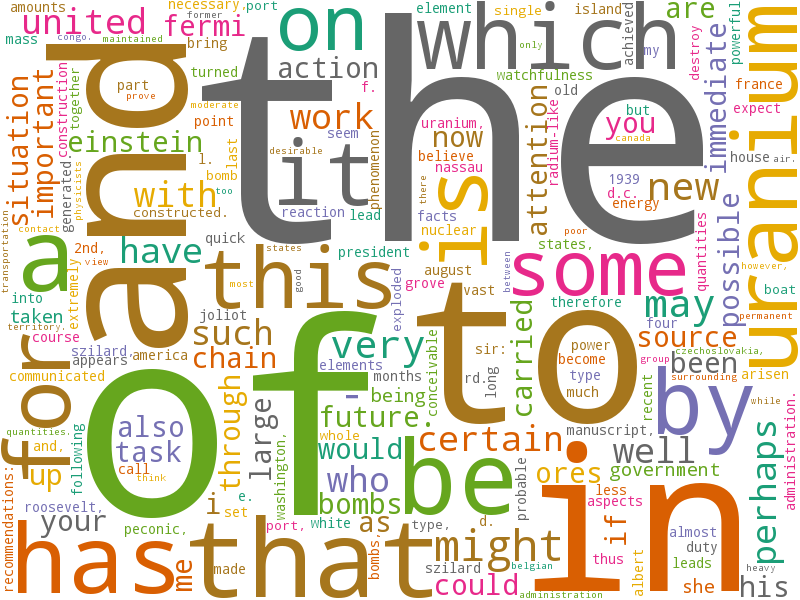

In [19]:
eval_mathics(
    'WordCloud[StringSplit[Import["ExampleData/EinsteinSzilLetter.txt", CharacterEncoding->"UTF8"]]] // MathMLForm'
)


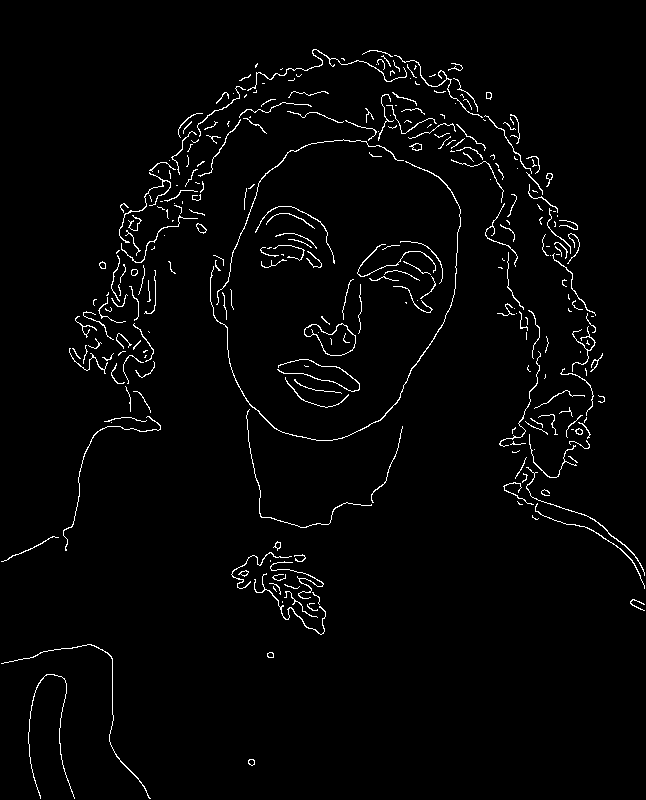

In [20]:
eval_mathics('EdgeDetect[Import["ExampleData/hedy.tif"], 5] // MathMLForm')

In [21]:
eval_mathics("Apart[1 / (x^2 - y^2), x]")

<IPython.core.display.Math object>

In [22]:
eval_mathics(
    """
    With[{f = {Cos[x] + Sin[x], Sin[x]}}, 
     Graphics[
      Table[{Hue[t/(2 Pi), 1, .8], Line[{f, Normalize[D[f, x]] + f}]} /. 
        x -> t, {t, 0, 2 Pi, .1}]]]
    """
)

In [23]:
eval_mathics("Integrate[Sin[x] ^ 5, x]")

<IPython.core.display.Math object>

In [24]:
eval_mathics("Series[Exp[x-y], {x, 0, 2}, {y, 0, 2}]")

<IPython.core.display.Math object>

In [25]:
eval_mathics(
    """
    Graphics[
     Table[{EdgeForm[Black], Hue[RandomReal[]], 
       Disk[RandomReal[4, {2}], RandomReal[1]]}, {40}]]
   """
)

In [26]:
eval_mathics(
    """
    Graphics[
     Table[{Hue[t/15, 1, .9, .3], 
       Disk[{Cos[2 Pi t/15], Sin[2 Pi t/15]}]}, {t, 15}]]
    """
)

In [27]:
eval_mathics(
    """
    Graphics[{Red, Disk[{0, 0}, 2, {0, Pi}], Blue, 
        Disk[{0, 0}, 2, {Pi, 2 Pi}], Red, Disk[{-1, 0}, 1], Blue, 
        Disk[{1, 0}, 1]}, ImageSize -> 150]
    """
)

In [28]:
eval_mathics(
    "Solve[{3 x ^ 2 - 3 y == 0, 3 y ^ 2 - 3 x == 0}, {x, y}] // Simplify"
)

<IPython.core.display.Math object>

In [29]:
eval_mathics("Graphics[Line[AnglePath[RandomReal[{-1, 1}, {100}]]]]")

In [30]:
eval_mathics("Nest[Subsuperscript[#,#,#]&,0,5]")

<IPython.core.display.Math object>

In [31]:
eval_mathics(
    """
    lindenmayer[i_, b_, h_, j_, r_, n_] :=
     (a = h; p = j; s = k = {}; t = Flatten;
      (Switch[#,
          6, s = {a, p, s},
          8, {a, p, s} = s,
          _C, k = {k, Line@{p, p += {Cos@a, Sin@a}}}];
         If[# < 9, a += I^# b ]) & /@ t@Nest[# /. r &, i, n];
      Graphics@t@k);
    lindenmayer[{C[1], X}, Pi/2, 0, {0, 0}, {X -> {X, 4, Y, C[1]}, Y -> {C[1], X, 2, Y}}, 10]
    """
)

In [32]:
eval_mathics("CompleteGraph@20")

In [33]:
eval_mathics('ListPlot[Table[ElementData[z, "AtomicWeight"], {z, 118}]]')

In [34]:
eval_mathics(
    "Clear[a]; RSolve[{a[n + 2] == a[n], a[0] == 1, a[1] == 4}, a, n]"
)

<IPython.core.display.Math object>

In [35]:
eval_mathics("BinomialTree[3, DirectedEdges->True]")

In [36]:
eval_mathics('GraphData["PappusGraph"]')